# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Для проведения исследования получим данные и подготовим их, затем исследуем баланс классов, обучим модель без учёта дисбаланса. Следующим шагом улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. И в заключении проведем тестирование выбраной модели на тестовой выборке

# 1. Подготовка данных

In [1]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore") 

In [2]:
# получим данные
data = pd.read_csv('/datasets/Churn.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Признаки
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — количество недвижимости у клиента
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
### Целевой признак
Exited — факт ухода клиента

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### В столбце Tenure - количество недвижимости имеются отсутствующие значения NaN.  Заменим нулевые

In [4]:
data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

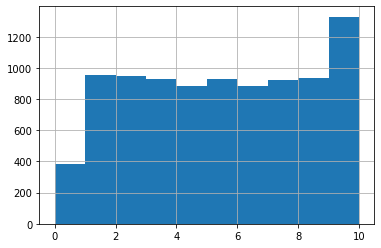

In [5]:
data['Tenure'].hist()

In [6]:
data = data.fillna(0)

### Среди признаков три находятся в текстовом формате: Surname, Geography, Gender. Обработаем их

### Мы замечаем, что функции RowNumber, CustomerId и Surname бесполезны для нас. Таким образом, мы можем удалить их из данных

In [7]:
# удалим столбец фамилия клиента
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)

### К признакам Geography и Gender применим прямое преобразование признаков в числовое

In [8]:
# прямое преобразование признаков в числовое приэтом удалим первый столбец для избегания дамми-ловушки
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Выделим из общей таблицы признаки и целевой признак

In [9]:
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis=1)

###  Разделим на обучающую (train) , тестовую (test) и валидационную (valid) выборки в соотношении 70:15:15 

In [10]:
features_train, features, target_train, target = train_test_split(features, target, test_size=0.30, 
                                                                              random_state=12345 )

In [11]:
features_test, features_valid, target_test, target_valid = train_test_split(features, target, test_size=0.5, 
                                                                              random_state=12345 )

### Проведем маштабирование признаков

In [12]:
numeric = ['Age','CreditScore','Tenure','Balance','EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9716,1.658077,0.012853,0.140188,0.635477,3,1,1,1.480907,1,0,1
224,0.198643,0.584111,0.461825,0.375870,1,1,1,0.153167,1,0,1
589,-1.374648,0.774530,0.461825,1.302947,2,0,0,0.817773,0,1,0
7507,-0.784664,0.488901,1.426737,0.696496,1,1,0,0.329403,1,0,1
1457,2.051400,2.583513,-0.181449,-1.222967,2,0,1,-0.617269,0,0,1


### Данные готовы для проведения иследования

# 2. Исследование задачи

### Исследуем баланс классов, обучим модель без учёта дисбаланса. Сделаем краткие выводы.

In [13]:
model_LR = LogisticRegression(random_state=12345, solver='liblinear')
model_LR.fit(features_train, target_train)
predicted_valid_LR = model_LR.predict(features_valid)
accuracy_LR = accuracy_score(target_valid, predicted_valid_LR)
accuracy_LR

0.796

### Построим матрицу ошибок для линейной регрессии

In [14]:
confusion_matrix(target_valid, predicted_valid_LR)

array([[1134,   47],
       [ 259,   60]])

### Рассмотрим полноту, точность и F-1 меру для линейной регрессии

In [15]:
print('Полнота', recall_score(target_valid, predicted_valid_LR))
print('Точность', precision_score(target_valid, predicted_valid_LR))
print('F-1 мера', f1_score(target_valid, predicted_valid_LR))

Полнота 0.18808777429467086
Точность 0.5607476635514018
F-1 мера 0.28169014084507044


### модель показала низкие значения полноты и F -1 меры, следовательно эту модель необходимо улучшить

### Обучим модель для решающего дерева

In [16]:
i = 0
result = pd.DataFrame(columns=['max_depth', 'accuracy'])
for max_depth in range(1, 15, 2): 
    tree = DecisionTreeClassifier(random_state=12345, max_depth = max_depth)
    tree.fit(features_train, target_train)
    predicted_valid_tree = tree.predict(features_valid)
    accuracy_tree = accuracy_score(target_valid, predicted_valid_tree)
    result.loc[i] = [max_depth, accuracy_tree] 
    i += 1
result.sort_values('accuracy', ascending=False)

,max_depth,accuracy
2,5.0,0.844000
4,9.0,0.843333
3,7.0,0.841333
1,3.0,0.828667
5,11.0,0.820000
6,13.0,0.808000
0,1.0,0.787333


### Выберем модель с глубиной дерева равным 5

In [17]:
tree = DecisionTreeClassifier(random_state=12345, max_depth = 5)
tree.fit(features_train, target_train)
predicted_valid_tree = tree.predict(features_valid)

### Построим матрицу ошибок для решающего дерева

In [18]:
confusion_matrix(target_valid, predicted_valid_tree)

array([[1119,   62],
       [ 172,  147]])

### Рассмотрим полноту, точность и F-1 меру для решающего дерева

In [19]:
print('Полнота', recall_score(target_valid, predicted_valid_tree))
print('Точность', precision_score(target_valid, predicted_valid_tree))
print('F-1 мера', f1_score(target_valid, predicted_valid_tree))

Полнота 0.4608150470219436
Точность 0.7033492822966507
F-1 мера 0.5568181818181818


### модель решающего дерева показала среднии значения полноты и F-1 меры и также нуждается в улучшении

In [20]:
i = 0
result = pd.DataFrame(columns=['n_estimators','max_depth', 'accuracy'])
for n_estimators in range(10, 101, 10):
     for max_depth in range(1, 10, 2): 
        model_RFR = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=max_depth)
        model_RFR.fit(features_train, target_train)  
        predicted_valid_RFR = model_RFR.predict(features_valid)
        accuracy_RFR = accuracy_score(target_valid, predicted_valid_RFR)
        result.loc[i] = [n_estimators, max_depth, accuracy_RFR]
        i += 1
result.sort_values('accuracy', ascending=False).head(5)

,n_estimators,max_depth,accuracy
29,60.0,9.0,0.847333
24,50.0,9.0,0.846667
49,100.0,9.0,0.846000
34,70.0,9.0,0.846000
14,30.0,9.0,0.846000


### Выберем модель с количеством деревьев равным 60 и глубиной дерева равным 9

In [21]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=9)
model_forest.fit(features_train, target_train)  
predicted_valid_forest = model_forest.predict(features_valid)

### Построим матрицу ошибок для случайного леса

In [22]:
confusion_matrix(target_valid, predicted_valid_forest)

array([[1143,   38],
       [ 191,  128]])

### Рассмотрим полноту, точность и F-1 меру для случайного леса

In [23]:
print('Полнота', recall_score(target_valid, predicted_valid_forest))
print('Точность', precision_score(target_valid, predicted_valid_forest))
print('F-1 мера', f1_score(target_valid, predicted_valid_forest))

Полнота 0.4012539184952978
Точность 0.7710843373493976
F-1 мера 0.5278350515463917


### модель случайного леса показала низкое значения полноты и среднее значение F-1 меры и также нуждается в улучшении

### на основе оценки  f1, которая лучше всего подходит для оценки лучшей модели в несбалансированном наборе данных, мы выбираем модель на основе случайного леса.

# 3. Борьба с дисбалансом

### Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. Кратко опишим выводы.

### Улучшим качество модели, применив взвешивание классов через аргумент class_weight присвоив иму значение balanced

In [24]:
model_RFR = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=7, class_weight='balanced')
model_RFR.fit(features_train, target_train)  
predicted_valid_RFR = model_RFR.predict(features_valid)

In [25]:
print('Полнота', recall_score(target_valid, predicted_valid_RFR))
print('Точность', precision_score(target_valid, predicted_valid_RFR))
print('F-1 мера', f1_score(target_valid, predicted_valid_RFR))

Полнота 0.677115987460815
Точность 0.5255474452554745
F-1 мера 0.5917808219178082


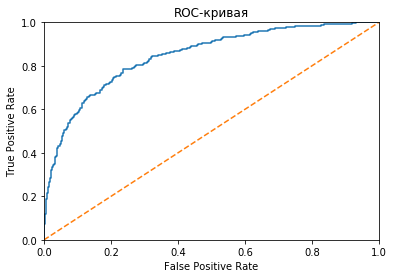

In [26]:
# Построим график -ROC кривая
probabilities_valid = model_RFR.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [27]:
# Вычислим значение метрикми AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8456942339391462

### После улучшение модели метрика полнота и F-1 мера увеличились до 0.59. Значение метрики AUC-ROC составило около 0.84

### Применим для улучшения модели метод увеличения выборки

In [28]:
# посмотрим соотношение положительных и отрицательных целевых признаков
target_train.value_counts()

0    5589
1    1411
Name: Exited, dtype: int64

In [29]:
# создадим функцию увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [30]:
# посмотрим соотношение положительных и отрицательных целевых признаков после увеличения выборки
target_upsampled.value_counts()

1    5644
0    5589
Name: Exited, dtype: int64

In [31]:
# обучим модель с учетом увеличенной выборки
model_RFC = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=9)
model_RFC.fit(features_upsampled,target_upsampled)  
predicted_valid_RFC = model_RFC.predict(features_valid)

In [32]:
print('Полнота', recall_score(target_valid, predicted_valid_RFC))
print('Точность', precision_score(target_valid, predicted_valid_RFC))
print('F-1 мера', f1_score(target_valid, predicted_valid_RFC))

Полнота 0.7147335423197492
Точность 0.5480769230769231
F-1 мера 0.6204081632653061


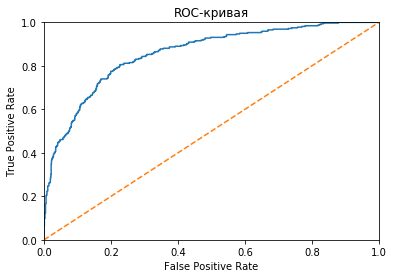

In [33]:
# Построим график -ROC кривая
probabilities_valid = model_RFC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [34]:
# Вычислим значение метрикми AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8568544801573504

### После улучшение модели метрика полнота и F-1 мера увеличились на большую величину по сравнению с улучшением через взвешивание классов через аргумент class_weight и составила 0.62. Значение метрики AUC-ROC составило около 0.85, что также чуть больше чем у предыдущей модели

### Основываясь на расмотренных метриках, для проверки на тестовой выборке используем модель случайного леса обученного на увеличенной выборке

# 4. Тестирование модели

### Проведем тестирование выбраной модели на тестовой выборке

In [35]:
predicted_test_RC = model_RFC.predict(features_test)

In [36]:
print('Полнота', recall_score(target_test, predicted_test_RC))
print('Точность', precision_score(target_test, predicted_test_RC))
print('F-1 мера', f1_score(target_test, predicted_test_RC))

Полнота 0.7328990228013029
Точность 0.5555555555555556
F-1 мера 0.6320224719101123


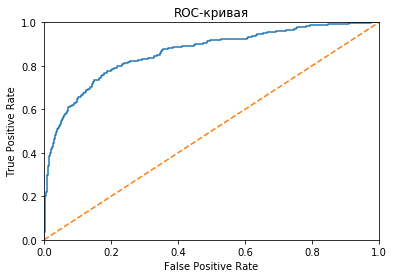

In [37]:
# Построим график -ROC кривая
probabilities_valid = model_RFC.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [38]:
# Вычислим значение метрикми AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
auc_roc

0.8609860450892967

### Проверка на тестовой выборке показала правильность выбранной модели, при этом метрика F-1мера составила 0.63, а  значение метрики AUC-ROC составило около 0.86, что хоть и лучше чем значение у случайной модели, но далеко от идеальных значений равных 1

##  В данном иследовании проведен выборм модели позволяющей спрогнозировать отток клиентов банка на основании данных за предыдущий период. Наиболее подходящей для выполнения данной задачи подошла модель случайного леса обученная на увеличенной выборке. 

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*